### LIBRARIES IMPORT

In [1]:
import pandas as pd
import numpy as np
import datetime

import os
from os.path import join

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Dense, LSTM, TimeDistributed, Input

import seaborn as sns
import matplotlib.pyplot as plt

### function for RMSLE

In [2]:
def rmsle(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5

### DATA 받기

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/hackathon/data'

# air reservation system
air_reserve = pd.read_csv(data_dir + '/air_reserve.csv')
air_store_info = pd.read_csv(data_dir + '/air_store_info.csv')
air_visit_data = pd.read_csv(data_dir + '/air_visit_data.csv')

# hpg reservation system
hpg_reserve = pd.read_csv(data_dir + '/hpg_reserve.csv')
hpg_store_info = pd.read_csv(data_dir + '/hpg_store_info.csv')

# additional data
store_id_relation = pd.read_csv(data_dir + '/store_id_relation.csv')
date_info = pd.read_csv(data_dir + '/date_info.csv')

# test data
sample_sub = pd.read_csv(data_dir + '/sample_submission.csv')

### DATA 설명

**`air_reserve.csv`**
- `air_store_id` : AIR 등록 레스토랑의 고유 ID
- `visit_datetime` : 예약을 통해 방문이 완료된 날짜
- `reserve_datetime` : 예약한 날짜입니다.
- `reserve_visitors` : 해당 예약의 방문자 수

**`air_store_info.csv`**
- `air_store_id` : AIR 등록 레스토랑의 고유 ID
- `air_genre_name` : 식당 종류
- `air_area_name` : 레스토랑의 지역명
- `latitude` : 레스토랑의 위도
- `longitude` : 레스토랑의 경도

**`air_visit_data.csv`**
- `air_store_id` : AIR 등록 레스토랑 고유 ID
- `visit_date` : 날짜
- `visitors` : 당일 레스토랑 방문객 수
---

**`hpg_reserve.csv`**
- `hpg_store_id` : HPG 등록 레스토랑의 고유 ID
- `hpg_genre_name` : 식당 종류
- `hpg_area_name` : 식당 영역명
- `latitude` : 레스토랑의 위도
- `longitude` : 레스토랑의 경도

**`hpg_store_info.csv`**
- `hpg_store_id` : HPG 데이터베이스의 레스토랑에 대한 고유 ID입니다.
- `visit_datetime` : 예약 시간
- `reserve_datetime` : 예약한 시간
- `reserve_visitors` : 해당 예약에 대한 방문자 수
---

**`store_id_relation.csv`**
- `id` : id는 air_store_id 및 visit_date를 밑줄과 연결하여 형성됩니다.
- `visitors` : 스토어 및 날짜 조합에 대해 예상되는 방문자 수

**`date_info.csv`**
- `calendar_date` : 날짜
- `day_of_week` : 요일
- `holiday_flg` : 만약 그날이 휴일이었다면? 1: 예, 0: 아니요.
---

**`sample_submission.csv`**
- `hpg_store_id` : HPG 고유 ID
- `air_store_id` : AIR 고유 ID

### DATA 준비

---

#### TEST DATA - sample_sub

In [4]:
sample_sub.head(3)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0


In [5]:
# transform test data
air_test = sample_sub.copy()
air_test['air_store_id'] = air_test['id'].apply(lambda x: str(x)[:-11])
air_test['visit_date'] = air_test['id'].apply(lambda x: str(x)[-10:])

# 예측을 위한 데이터
submission_lstm = air_test.copy()

# test set for merger with train set
air_test = air_test.drop(['id', 'visitors'], axis = 1)

In [6]:
air_test.head(3)

,air_store_id,visit_date
0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9,2017-04-25


### visitor

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


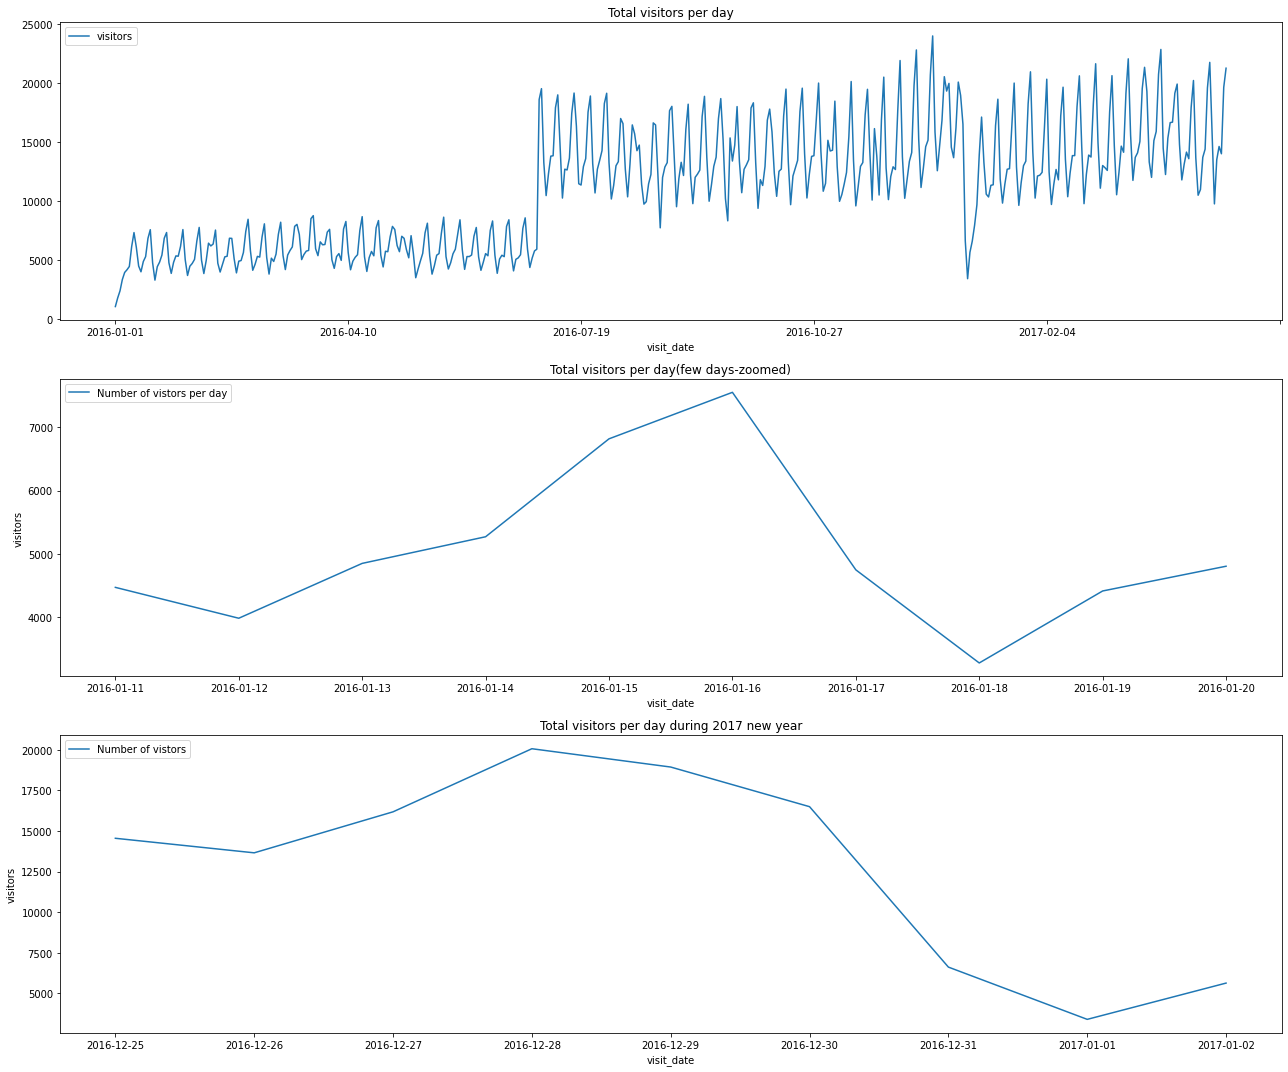

<Figure size 432x288 with 0 Axes>

In [7]:
# per day visitors
fig = plt.figure(figsize=(18,15))

ax1 = fig.add_subplot(311)

temp = air_visit_data.groupby("visit_date").visitors.sum()

temp.plot()
plt.title("Total visitors per day")
plt.legend(loc='upper left')

ax2 = fig.add_subplot(312)
sns.lineplot(temp.index[10:20], temp[10:20], ax=ax2, label="Number of vistors per day")
plt.legend(loc='upper left')
plt.title("Total visitors per day(few days-zoomed)")


temp = temp.loc['2016-12-25': '2017-01-02']

ax3 = fig.add_subplot(313)
sns.lineplot(temp.index, temp, ax=ax3, label="Number of vistors")
plt.title("Total visitors per day during 2017 new year")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.savefig("Visitors_trend_across_the_days.png", bbox_inches='tight')

- 1번 그래프 : 고객의 수가 7월 기점으로 등락 폭이 있다. DB에 식당이 추가되기 때문이다.
- 3번 그래프 : 17-01-01 기간에도 방문객이 급감하고 있는데 새해때문이다.

---

#### 예약 데이터 -  DATA ON RESERVATION 

In [8]:
# air 와 hpg databases를 합친다.
hpg_air_reserve = store_id_relation.join(hpg_reserve.set_index('hpg_store_id'), on = 'hpg_store_id')
air_reserve_tmp = air_reserve.copy()
hpg_air_reserve = hpg_air_reserve.drop('hpg_store_id', axis = 1)
reserve = pd.concat([air_reserve_tmp, hpg_air_reserve])

In [9]:
reserve.head(1)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1


In [10]:
reserve.visit_datetime[:1]

0    2016-01-01 19:00:00
Name: visit_datetime, dtype: object

In [11]:
# 전환!! columns of "reserve" table into datetime 형식으로
reserve['visit_datetime'] =  pd.to_datetime(reserve['visit_datetime'])
reserve['reserve_datetime'] =  pd.to_datetime(reserve['reserve_datetime'])

In [12]:
reserve.visit_datetime[:1]

0   2016-01-01 19:00:00
Name: visit_datetime, dtype: datetime64[ns]

In [13]:
# column for visit date inside "reserve" table 만들어 준다.
reserve['visit_date'] = reserve['visit_datetime'].apply(lambda x: str(x)[0:10])

# visit time과 reservation time 사이의 차이를 계산한다.
reserve['hour_gap'] = reserve['visit_datetime'].sub(reserve['reserve_datetime'])
reserve['hour_gap'] = reserve['hour_gap'].apply(lambda x: x/np.timedelta64(1,'h'))
# 시간에서 시간을 뺀것.

# gap의 차이에 따라 예약을 5개의 범주로 분리해준다.
reserve['reserve_-12_h'] = np.where(reserve['hour_gap'] <= 12,
                                    reserve['reserve_visitors'], 0)
reserve['reserve_12_37_h'] = np.where((reserve['hour_gap'] <= 37) & (reserve['hour_gap'] > 12),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_37_59_h'] = np.where((reserve['hour_gap'] <= 59) & (reserve['hour_gap'] > 37),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_59_85_h'] = np.where((reserve['hour_gap'] <= 85) & (reserve['hour_gap'] > 59),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_85+_h'] = np.where((reserve['hour_gap'] > 85),
                                     reserve['reserve_visitors'], 0)

# air_store_id 및 visit_date별로 그룹화하여 기본 테이블과 결합 사용 한다.
group_list = ['air_store_id', 'visit_date', 'reserve_visitors', 'reserve_-12_h',
              'reserve_12_37_h', 'reserve_37_59_h', 'reserve_59_85_h', 'reserve_85+_h']
reserve = reserve[group_list].groupby(['air_store_id', 'visit_date'], as_index = False).sum()

for i in group_list[2:]:
    reserve[i] = reserve[i].apply(lambda x: np.log1p(x))

In [14]:
reserve.head(7)

,air_store_id,visit_date,reserve_visitors,reserve_-12_h,reserve_12_37_h,reserve_37_59_h,reserve_59_85_h,reserve_85+_h
0,air_00a91d42b08b08d9,2016-01-14,1.098612,0.0,0.0,0.000000,1.098612,0.000000
1,air_00a91d42b08b08d9,2016-01-15,1.609438,0.0,0.0,0.000000,0.000000,1.609438
2,air_00a91d42b08b08d9,2016-01-16,1.098612,0.0,0.0,0.000000,1.098612,0.000000
3,air_00a91d42b08b08d9,2016-01-22,1.098612,0.0,0.0,0.000000,1.098612,0.000000
4,air_00a91d42b08b08d9,2016-01-29,1.791759,0.0,0.0,0.000000,0.000000,1.791759
5,air_00a91d42b08b08d9,2016-02-05,1.098612,0.0,0.0,0.000000,0.000000,1.098612
6,air_00a91d42b08b08d9,2016-03-08,1.386294,0.0,0.0,1.386294,0.000000,0.000000


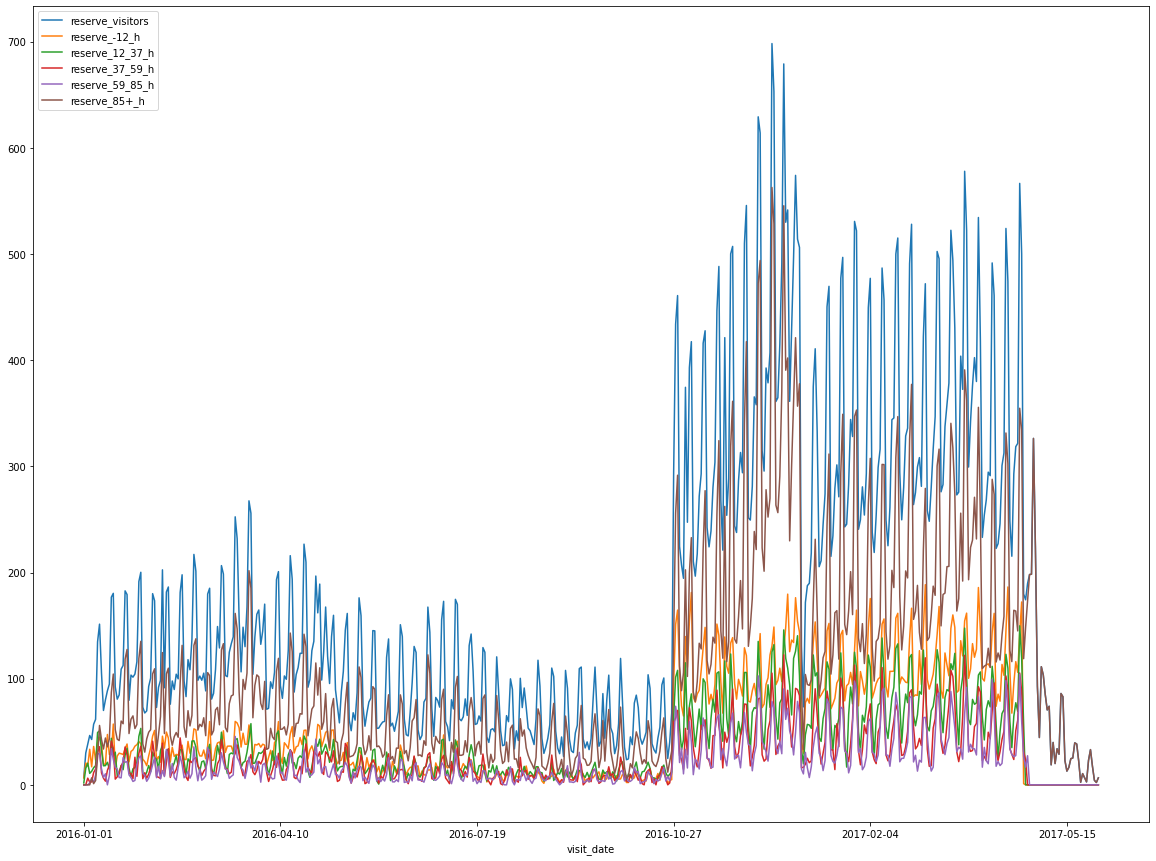

In [15]:
temp = reserve.groupby("visit_date").sum()
temp.plot(figsize=(20,15))
plt.legend(loc='upper left')

---

#### 장르 - GENRE DATA 

In [16]:
air_store_info[:3]

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853


In [17]:
# 특정 장르 레스토랑의 총 식당 수 by area_bame
# 내가 원하는 열을 기준으로 그룹화
air_genres_area = air_store_info.copy()
air_genres_area = air_genres_area[['air_store_id', 'air_genre_name', 'air_area_name']].groupby(['air_genre_name', 'air_area_name'],
                                                                                              as_index = False).count()
air_genres_area = air_genres_area.rename(columns = {'air_store_id': 'genre_in_area'})

# 지역안에 총 식당 수
air_area = air_store_info.copy()
air_area = air_area[['air_store_id', 'air_area_name']].groupby(['air_area_name'], as_index = False).count()
air_area = air_area.rename(columns = {'air_store_id': 'total_r_in_area'})

In [18]:
 air_area[:3]

,air_area_name,total_r_in_area
0,Fukuoka-ken Fukuoka-shi Daimyō,64
1,Fukuoka-ken Fukuoka-shi Hakata Ekimae,16
2,Fukuoka-ken Fukuoka-shi Imaizumi,2


---

#### WEEKEND AND HOLIDAYS

In [19]:
# 주말 및 휴일을 위한 추가 기능
date_info_mod = date_info.copy()
date_info_mod['holiday_eve'] = np.zeros(date_info_mod.shape[0])
date_info_mod['holiday_eve'].iloc[:-1] = date_info_mod['holiday_flg'].copy().values[1:]
date_info_mod['non_working'] = np.where(date_info_mod['day_of_week'].isin(['Saturday', 'Sunday']) |
                                        date_info_mod['holiday_flg'] == 1, 1, 0)
date_info_mod = date_info_mod.drop('holiday_flg', axis = 1)

# 근무일수 및 휴무일수별 식당당 평균 방문객 수
air_visit_wd = air_visit_data.join(date_info_mod.set_index('calendar_date'), on = 'visit_date')
air_visit_wd['visitors'] = air_visit_wd['visitors'].apply(lambda x: np.log1p(x)) 

# 평균 visitors per restaurant
mean_df = air_visit_wd[['visitors',
                        'air_store_id',
                        'non_working']].copy().groupby(['air_store_id',
                                                        'non_working'],
                                                        as_index = False).mean()
mean_df = mean_df.rename(columns = {'visitors': 'visitors_mean'})


# 중앙값 visitors per restaurant
median_df = air_visit_wd[['visitors',
                          'air_store_id',
                          'non_working']].copy().groupby(['air_store_id',
                                                          'non_working'],
                                                          as_index = False).median()
median_df = median_df.rename(columns = {'visitors': 'visitors_median'})

# 최대 visitors per restaurant
max_df = air_visit_wd[['visitors',
                       'air_store_id',
                       'non_working']].copy().groupby(['air_store_id',
                                                       'non_working'],
                                                       as_index = False).max()
max_df = max_df.rename(columns = {'visitors': 'visitors_max'})

# 최소 visitors per restaurant
min_df = air_visit_wd[['visitors',
                       'air_store_id',
                       'non_working']].copy().groupby(['air_store_id',
                                                       'non_working'],
                                                       as_index = False).min()
min_df = min_df.rename(columns = {'visitors': 'visitors_min'})

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


---

#### JOIN TABLES INTO TRAINING AND TEST SETS

In [20]:
# function for combining train/test dataset with additional information
def merge_join(df):
    # add month of visit
    df['month'] = df['visit_date'].apply(lambda x: float(str(x)[5:7]))

    # add weekday and holiday flag
    df = df.join(date_info_mod.set_index('calendar_date'), on = 'visit_date')


    # add genre and area name)
    df = df.join(air_store_info.set_index('air_store_id'), on = 'air_store_id')

    # add quantity of same genre in area
    df = pd.merge(df, air_genres_area, how = 'left',
                  left_on = ['air_genre_name', 'air_area_name'],
                  right_on = ['air_genre_name', 'air_area_name'])


    # add total quatity of restaurants in area
    df = pd.merge(df, air_area, how = 'left',
                  left_on = ['air_area_name'],
                  right_on = ['air_area_name'])

    # add reservation information
    df = pd.merge(df, reserve, how = 'left',
                  left_on = ['air_store_id', 'visit_date'],
                  right_on = ['air_store_id', 'visit_date'])

    # add visitors number mean, median, max and min per each restaurant
    df = pd.merge(df, mean_df, how = 'left',
                  left_on = ['air_store_id', 'non_working'],
                  right_on = ['air_store_id', 'non_working'])

    df = pd.merge(df, median_df, how = 'left',
                  left_on = ['air_store_id', 'non_working'],
                  right_on = ['air_store_id', 'non_working'])
    
    df = pd.merge(df, max_df, how = 'left',
                  left_on = ['air_store_id', 'non_working'],
                  right_on = ['air_store_id', 'non_working'])
    
    df = pd.merge(df, min_df, how = 'left',
                  left_on = ['air_store_id', 'non_working'],
                  right_on = ['air_store_id', 'non_working'])
    
    # change NaN to 0
    df = df.fillna(0) 
   
    return df

# combine train/test data with additional information
air_train = air_visit_data.copy()
X = merge_join(air_train)
X_test = merge_join(air_test)

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   air_store_id      252108 non-null  object 
 1   visit_date        252108 non-null  object 
 2   visitors          252108 non-null  int64  
 3   month             252108 non-null  float64
 4   day_of_week       252108 non-null  object 
 5   holiday_eve       252108 non-null  float64
 6   non_working       252108 non-null  int64  
 7   air_genre_name    252108 non-null  object 
 8   air_area_name     252108 non-null  object 
 9   latitude          252108 non-null  float64
 10  longitude         252108 non-null  float64
 11  genre_in_area     252108 non-null  int64  
 12  total_r_in_area   252108 non-null  int64  
 13  reserve_visitors  252108 non-null  float64
 14  reserve_-12_h     252108 non-null  float64
 15  reserve_12_37_h   252108 non-null  float64
 16  reserve_37_59_h   25

In [22]:
X_test.head()

,air_store_id,visit_date,month,day_of_week,holiday_eve,non_working,air_genre_name,air_area_name,latitude,longitude,...,reserve_visitors,reserve_-12_h,reserve_12_37_h,reserve_37_59_h,reserve_59_85_h,reserve_85+_h,visitors_mean,visitors_median,visitors_max,visitors_min
0,air_00a91d42b08b08d9,2017-04-23,4.0,Sunday,0.0,1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,0.0,0.0,0.0,0.0,0.0,0.0,2.485089,2.484907,4.605170,1.098612
1,air_00a91d42b08b08d9,2017-04-24,4.0,Monday,0.0,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,0.0,0.0,0.0,0.0,0.0,0.0,3.309565,3.367296,4.060443,0.693147
2,air_00a91d42b08b08d9,2017-04-25,4.0,Tuesday,0.0,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,0.0,0.0,0.0,0.0,0.0,0.0,3.309565,3.367296,4.060443,0.693147
3,air_00a91d42b08b08d9,2017-04-26,4.0,Wednesday,0.0,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,0.0,0.0,0.0,0.0,0.0,0.0,3.309565,3.367296,4.060443,0.693147
4,air_00a91d42b08b08d9,2017-04-27,4.0,Thursday,0.0,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,0.0,0.0,0.0,0.0,0.0,0.0,3.309565,3.367296,4.060443,0.693147


#### 문자열 기능 인코딩 - ENCODE STRING FEATURES

In [24]:
# one-hot encoding이 더 나은 결과를 도출할 것으로 보인다
# 고차원의 feature space를 피하기 위해 label encoding을 사용한다

# Weekday
le_weekday = preprocessing.LabelEncoder()
le_weekday.fit(X['day_of_week'])
X['day_of_week'] = le_weekday.transform(X['day_of_week'])
X_test['day_of_week'] = le_weekday.transform(X_test['day_of_week'])

# Genre name
le_genre = preprocessing.LabelEncoder()
le_genre.fit(X['air_genre_name'])
X['air_genre_name'] = le_genre.transform(X['air_genre_name'])
X_test['air_genre_name'] = le_genre.transform(X_test['air_genre_name'])

# Area name
le_area = preprocessing.LabelEncoder()
le_area.fit(X['air_area_name'])
X['air_area_name'] = le_area.transform(X['air_area_name'])
X_test['air_area_name'] = le_area.transform(X_test['air_area_name'])

# id
le_id = preprocessing.LabelEncoder()
le_id.fit(X['air_store_id'])
X['air_store_id'] = le_id.transform(X['air_store_id'])
X_test['air_store_id'] = le_id.transform(X_test['air_store_id'])

#### Train 및 Test set의 동시 변환 - SIMULTANEOUS TRANSFORMATION OF TRAIN AND TEST SETS

In [25]:

# TRAIN SET과 TEST SET을 합쳐준다
X_all = X.append(X_test)

# date table (TRAIN SET과 TEST SET 전체 기간을 포함한 date table을 만들어 준다)
dates = np.arange(np.datetime64(X_all.visit_date.min()),
                  np.datetime64(X_all.visit_date.max()) + 1,
                  datetime.timedelta(days=1))
ids = X_all['air_store_id'].unique()
dates_all = dates.tolist()*len(ids)
ids_all = np.repeat(ids, len(dates.tolist())).tolist()
df_all = pd.DataFrame({"air_store_id": ids_all, "visit_date": dates_all})
df_all['visit_date'] = df_all['visit_date'].copy().apply(lambda x: str(x)[:10])

# 'visit_date'와 관련된 데이터로 X_all의 복사본을 만든다
X_dates = X_all[['visit_date', 'month', 'day_of_week', 'holiday_eve', 'non_working']].copy()

# 메모리 문제를 피하기 위해 중복된 데이터를 삭제해준다
X_dates = X_dates.drop_duplicates('visit_date')

# 각 레스토랑의 모든 날짜를 나타내는 데이터 프레임을 각 날짜에 대한 정보와 병합한다
df_to_reshape = df_all.merge(X_dates,
                             how = "left",
                             left_on = 'visit_date',
                             right_on = 'visit_date')

# 'air_store_id'와 관련된 데이터로 X_all의 복사본을 만든다
X_stores = X_all[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude',
                  'longitude', 'genre_in_area', 'total_r_in_area']].copy()       

# 메모리 문제를 피하기 위해 중복된 데이터를 삭제해준다
X_stores = X_stores.drop_duplicates('air_store_id')

# 각 레스토랑의 모든 날짜를 나타내는 데이터 프레임을 각 레스토랑에 대한 정보와 병합한다
df_to_reshape = df_to_reshape.merge(X_stores,
                                    how = "left",
                                    left_on = 'air_store_id',
                                    right_on = 'air_store_id')

# 각 레스토랑의 모든 날짜를 나타내는 데이터 프레임과 특정 날짜의 각 레스토랑에 대한 정보를 병합한다
df_to_reshape = df_to_reshape.merge(X_all[['air_store_id', 'visit_date', 'reserve_visitors', 'visitors_mean', 
                                       'visitors_median', 'visitors_max', 'visitors_min', 'visitors']],
                                    how = "left",
                                    left_on = ['air_store_id', 'visit_date'],
                                    right_on = ['air_store_id', 'visit_date'])

# 'visitors'를 출력 배열로 분리한다
Y_lstm_df = df_to_reshape[['visit_date', 'air_store_id', 'visitors']].copy().fillna(0)

# log(y+1)를 취한다
Y_lstm_df['visitors'] = np.log1p(Y_lstm_df['visitors'].values)

# 레스토랑이 문을 닫은 날짜에 대한 플래그를 추가한다
df_to_reshape['closed_flag'] = np.where(df_to_reshape['visitors'].isnull() &
                                        df_to_reshape['visit_date'].isin(X['visit_date']).values,1,0)

# 데이터셋에서 'visitors'를 삭제한다
df_to_reshape = df_to_reshape.drop(['visitors'], axis = 1)

# 결측치를 -1로 채워준다
df_to_reshape = df_to_reshape.fillna(-1)

# 'air_store_id', 'visit_date'가 없는 df_to_reshape 리스트
columns_list = [x for x in list(df_to_reshape.iloc[:,2:])]

# -1과 1 사이의 모든 숫자 값을 바인딩한다
# 이번 케이스에서는 test set의 모든 데이터를 train set에서 가져온다, 따라서 모든 데이터에 대해 fit/transform된다
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df_to_reshape[columns_list])
df_to_reshape[columns_list] = scaler.transform(df_to_reshape[columns_list])

#### SPECIFIC PREPARATION FOR NEURAL NETWORK AND ENCODER/DECODER

In [26]:
# (samples, timesteps, features)를 표본으로 X를 reshape한다
X_all_lstm = df_to_reshape.values[:,2:].reshape(len(ids),
                                                len(dates),
                                                df_to_reshape.shape[1]-2)

# train set의 출력을 분리하고, 시계열에 맞게 reshape한다
Y_lstm_df = Y_lstm_df.loc[Y_lstm_df['visit_date'].isin(X['visit_date'].values) &
                          Y_lstm_df['air_store_id'].isin(X['air_store_id'].values),]
Y_lstm = Y_lstm_df.values[:,2].reshape(len(X['air_store_id'].unique()),
                                       len(X['visit_date'].unique()),
                                       1)

# test dates
n_test_dates = len(X_test['visit_date'].unique())

# t-1, t-2, ... t-7의 방문자 수를 위한 features 추가한다
t_minus = np.ones([Y_lstm.shape[0],Y_lstm.shape[1],1])
for i in range(1,8):
    temp = Y_lstm.copy()
    temp[:,i:,:] = Y_lstm[:,0:-i,:].copy()
    t_minus = np.concatenate((t_minus[...], temp[...]), axis = 2)
t_minus = t_minus[:,:,1:]
print ("t_minus shape", t_minus.shape)


# X_all을 training data, test data로 분리한다
X_lstm = X_all_lstm[:,:-n_test_dates,:]
X_lstm_test = X_all_lstm[:,-n_test_dates:,:]

# feature vector에 t-1, t-2 ... t-7 visitors를 추가한다
X_lstm = np.concatenate((X_lstm[...], t_minus[...]), axis = 2)

# training set을 train set, validation set으로 나눠준다
X_tr = X_lstm[:,39:-140,:]
Y_tr = Y_lstm[:,39:-140,:]

X_val = X_lstm[:,-140:,:]
Y_val = Y_lstm[:,-140:,:]

t_minus shape (829, 478, 7)


### ENCODER-DECODER MODEL

#### MODEL FOR ENCODER AND DECODER 

In [28]:
num_encoder_tokens = X_lstm.shape[2]
latent_dim = 64 # "kernel run out of time"을 방지하도록 잘 조정해준다

# encoder training
encoder_inputs = Input(shape = (None, num_encoder_tokens))
encoder = LSTM(latent_dim, 
               batch_input_shape = (1, None, num_encoder_tokens),
               stateful = False,
               return_sequences = True,
               return_state = True,
               recurrent_initializer = 'glorot_uniform')

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c] # 'encoder_outputs'는 무시되고 상태만 유지된다

# 'encoder_states'를 초기 상태로 사용하는, Decoder training
decoder_inputs = Input(shape=(None, num_encoder_tokens))

decoder_lstm_1 = LSTM(latent_dim,
                      batch_input_shape = (1, None, num_encoder_tokens),
                      stateful = False,
                      return_sequences = True,
                      return_state = False,
                      dropout = 0.2,
                      recurrent_dropout = 0.2) # True

decoder_lstm_2 = LSTM(32, # "kernel run out of time"을 방지하도록 잘 조정해준다
                     stateful = False,
                     return_sequences = True,
                     return_state = True,
                     dropout = 0.2,
                     recurrent_dropout = 0.2)

decoder_outputs, _, _ = decoder_lstm_2(decoder_lstm_1(decoder_inputs, initial_state = encoder_states))
decoder_dense = TimeDistributed(Dense(Y_lstm.shape[2], activation = 'relu'))
decoder_outputs = decoder_dense(decoder_outputs)

# training model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
training_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#### GENERATOR APPLIED TO FEED ENCODER AND DECODER

In [29]:
# 연속된 39일의 시계열을 랜덤하게 생성하는 생성기
# 다음의 시계열은 다음과 같은 3D의 형태를 가진다: 829 restaurants * 39 days * num_features
def dec_enc_n_days_gen(X_3d, Y_3d, length):
    while 1:
        decoder_boundary = X_3d.shape[1] - length - 1
        
        encoder_start = np.random.randint(0, decoder_boundary)
        encoder_end = encoder_start + length
        
        decoder_start = encoder_start + 1
        decoder_end = encoder_end + 1
        
        X_to_conc = X_3d[:, encoder_start:encoder_end, :].astype(float)
        Y_to_conc = Y_3d[:, encoder_start:encoder_end, :].astype(float)
        X_to_decode = X_3d[:, decoder_start:decoder_end, :].astype(float)
        Y_decoder = Y_3d[:, decoder_start:decoder_end, :].astype(float)
        
        yield([X_to_conc,
               X_to_decode],
               Y_decoder)

#### TRAINING

In [31]:
# X_tr/Y_tr로 훈련, X_val/Y_val로 검증한다
# validation data에 대한 validation 훈련을 수행하려면 전체 데이터셋이 아닌 검증 데이터에 대한 validation 훈련을 수행한다
# 학습 데이터 이외의 기간에 대해 유효성 검사를 수행한다
'''
training_model.fit_generator(dec_enc_n_days_gen(X_tr, Y_tr, 39),
                             validation_data = dec_enc_n_days_gen(X_val, Y_val, 39),
                             steps_per_epoch = X_lstm.shape[0],
                             validation_steps = X_val.shape[0],
                             verbose = 1,
                             epochs = 1)
'''

# 전체 데이터셋에 대한 훈련
training_model.fit_generator(dec_enc_n_days_gen(X_lstm[:,:,:], Y_lstm[:,:,:], 39),
                            steps_per_epoch = X_lstm[:,:,:].shape[0],
                            verbose = 1,
                            epochs = 1)

829/829 [==============================] - 222s 267ms/step - loss: 0.1868


#### PREDICTION FUNCTION

In [ ]:
# 함수는 첫 번째 예측일 전까지 39일이 걸린다(input_seq)
# 그런 다음, 인코더를 사용하여 이 39일 동안 hidden states를 식별한다
# 다음으로, 디코더는 인코더가 제공하는 hidden states를 취한다
# 2일차부터 40일차까지 방문자 수를 예측한다
# 40일은 target_seq의 첫 번째 날을 의미한다

# 40일차의 예측 값은 41일의 피쳐에 추가된다
# 그런 다음 함수는 2일에서 40일까지의 기간이 소요되며, 대상 시퀀스의 모든 날짜가 예측을 얻을 때까지 프로세스를 반복한다

# 함수의 출력은 다음과 같은 예측이 포함된 벡터입니다.
# shape: 820 restaurants * 39 days * 1 predicted visitors amount


def predict_sequence(inf_enc, inf_dec, input_seq, Y_input_seq, target_seq):
    # encoder에 의해 생성된 입력 시퀀스의 상태 
    state = inf_enc.predict(input_seq)
    
    # target 시퀀스를 X_lstm_test와 같은 모양으로 제한해준다
    target_seq = target_seq[:,:, :X_lstm_test.shape[2]]
    
    
    # 이전의 7일이 포함된 y에 대한 벡터를 만든다
    t_minus_seq = np.concatenate((Y_input_seq[:,-1:,:], input_seq[:,-1:, X_lstm_test.shape[2]:-1]), axis = 2)
    
    # prediction 루프의 각 반복에서 수정될 현재 시퀀스
    current_seq = input_seq.copy()
    
    
    # output 예측
    output = np.ones([target_seq.shape[0],1,1])
    for i in range(target_seq.shape[1]):
        # new day에 대한 features에 이전의 7일에 대한 방문자를 추가한다
        new_day_features = np.concatenate((target_seq[:,i:i+1,:], t_minus_seq[...]), axis = 2)
        
        # 예측 기간을 하루 앞으로 이동해준다
        current_seq = np.concatenate((current_seq[:,1:,:], new_day_features[:,]), axis = 1)
        
        
        # visitors 양 예측
        pred = inf_dec.predict([current_seq] + state)
        
        # t_minus_seq 업데이트
        t_minus_seq = np.concatenate((pred[:,-1:,:], t_minus_seq[...]), axis = 2)
        t_minus_seq = t_minus_seq[:,:,:-1]        
        
        # update predicitons list 업데이트
        output = np.concatenate((output[...], pred[:,-1:,:]), axis = 1)
        
        # state 업데이트
        state = inf_enc.predict(current_seq)
    
    return output[:,1:,:]

#### INFERENCE ENCODER AND DECODER

In [ ]:
# inference(추론) encoder
encoder_model = Model(encoder_inputs, encoder_states)

# inference decoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs,_,_ = decoder_lstm_2(decoder_lstm_1(decoder_inputs,
                                                    initial_state = decoder_states_inputs))
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs])

#### VALIDATION ON PERIOD OUTSIDE OF TRAINING DATA 

In [ ]:
# "training_model"은 X_tr에서 훈련된 후에, validation에서 사용해야 한다

'''
val_list = []

for i in range(5):
    
    start = np.random.randint(0, int(X_val.shape[1]-X_lstm_test.shape[1]*2))
    end = start+39
    dec_start = end
    dec_end = dec_start+39

    predictions = predict_sequence(encoder_model,
                                   decoder_model,
                                   X_val[:,start:end,:],
                                   Y_val[:,start:end,:],
                                   X_val[:,dec_start:dec_end,:])
    score = rmsle(Y_val[:,dec_start:dec_end,:].reshape(X_val[:,start:end,:].shape[0]*39), 
                  predictions.reshape(X_val[:,start:end,:].shape[0]*39))
    val_list.append(score)

print (np.asarray(val_list).mean())
print (np.asarray(val_list).std())
'''

# 테스트 값 예측
enc_dec_pred = predict_sequence(encoder_model,
                                decoder_model,
                                X_lstm[:,-X_lstm_test.shape[1]:,:].astype(float),
                                Y_lstm[:,-X_lstm_test.shape[1]:,:].astype(float),
                                X_lstm_test[:,:,:].astype(float))

#### Add predicted test values to submission dataset

In [ ]:
# 참고: 시계열의 순서를 유지하는 것이 중요
# 따라서 test set에는 train set과 같은 순서로 829개의 라인이 모두 포함된다
# 이를 만들기 위해 'air_store_id'는 X_test가 아닌 X에서와 같이 사용된다(아래 'test' 변수의 두 번째 줄)
# submission 데이터 프레임에 관련된 결과만 병합된다

test = df_to_reshape.loc[df_to_reshape['visit_date'].isin(X_test['visit_date'].values) &
                         df_to_reshape['air_store_id'].isin(X['air_store_id'].values),]


# 예측값을 초기 형태로 reshape
test_pred = enc_dec_pred.reshape(test.shape[0], 1)
test_pred_exp = np.exp(test_pred) - 1.0
test_pred_exp[test_pred_exp<0] = 0

# 'air_store_id', 'visit_date'가 있는 데이터 프레임에 예측 추가
test_df_pred = test[['air_store_id', 'visit_date']].copy()
test_df_pred['predicted'] = test_pred_exp

# 'air_store_id'의 역변환
test_df_pred['air_store_id'] = le_id.inverse_transform(test_df_pred['air_store_id'])

# submission.csv 파일 마무리
submission_df = submission_lstm.merge(test_df_pred,
                                     how = 'left',
                                     left_on = ['air_store_id', 'visit_date'],
                                     right_on = ['air_store_id', 'visit_date'])

submission_df['visitors'] = submission_df['predicted']
submission_df = submission_df.drop(['air_store_id', 'visit_date', 'predicted'], axis = 1)
submission_df.to_csv('submission.csv', index = False)

![](https://8888-wadwcmvhk1c8fvjnvlw34oxdk.e.aiffel-4.ainetwork.ai/files/aiffel/hackathon/submission.JPG)

---
## 참고 kaggle
**Q1**. 선정이유
- 라이브러리를 불러올때 익숙해 보여서 공부하기에 좋을 것 같아 참고하였다.
- 과거의 데이터를 통해 미래를 예측하는게 목표이기에 LSTM이 적합하다고 판단해서 참고 하였다.


https://www.kaggle.com/ievgenvp/lstm-encoder-decoder-via-keras-lb-0-5 - LSTM \
https://www.kaggle.com/maestroyi/restaurant-visitor-forecasting-eda-with-r - 전처리 & 시각화


## 마무리
**Q1**. EDA 및 Visualization이 충실히 수행되었는가? (25%)
- 시각화를 어떻게 해야 하는지 알아가는 공부하는 목적으로 진행되었던것 같다.
- 최대한으로 팀원 모두 노력하였지만 와~ 구현 해봤다 정도인것 같다.

**Q2**. 데이터 전처리가 적절히 수행되었는가? (25%)
- 우수 했던 kaggle을 참고 하여 진행 하였기에 적절히 수행되었다고 본다.
- 조금씩은 다르지겠지만 별다른 큰 차이점은 없어서 아쉬움이 남는다.

**Q3**. 데이터 분석 과정이 충분히 설득력 있는가? (25%)
- 우수 했던 kaggle을 참고 하여 진행 하였기에 적절히 수행되었다고 본다.
- Q2와 같이 별다른 큰 차이점은 없어서 아쉬움이 남는다.

**Q4**. Public Score가 우수한가? (10%)
- 첫 시도로 0.5300 수준이었고 최종적으로 0.5048이 나왔다.

**Q5**. 팀원끼리 서로 협력하여 프로젝트를 수행하고 발표를 진행하였는가? (15%)
- 여러 kaggle을 참고 하면서 서로 공유를 진행 하였습니다.
- 모두가 Score를 올리기 위한 작업에 참여 하였습니다.
- 잘하진 못하지만 다같이 열심히하여 참여 하였습니다.


## 느낀점

#### 팀장 서연님 👍
-  해커톤을 시작하면서 처음에 어떻게 진행할 것인지 방향을 잡는 부분과 적절한 참고 자료를 정하는 부분도 쉽지 않았고
<br/> 다른 사람의 코드를 보면서 어떤 식으로 작성을 했는지 어떤 의도로 이렇게 작성을 한 건지 파악하는 부분이 제일 어려웠던 것 같다.
<br/> 처음에 참고한 자료는 스코어와 시각화 표현이 잘 되어있는 것만 집중을 해서 고른 자료라 
<br/> 세세하게 어떻게 짜여 있는지를 모르고 시작을 했는데 하나하나 코드를 분석해보면서 실행하는 중에 
<br/> data merge 하는 과정에서 hpg 부분의 결측치 때문에 전처리가 잘되지 않아 난항을 겪었다. 
<br/> 그래서 거의 시간이 남지 않은 상태에서 다시 참고할 자료들을 찾아 진행을 했는데 
<br/> 다시 찾은 참고 자료 역시 왜 LSTM을 사용했는지 같은 부분들을 이해하는데도 오래 걸렸다.
<br/> 관련 캐글 노드도 진행을 하였고 시각화나 전처리 하는 부분도 배운 내용인데 
<br/> 배운 걸 캐글 데이터에 따로 적용해가면서 진행 하는게 정말 힘들었다.
<br/><br/> 해커톤을 하면서 파이썬 공부를 더 깊게 공부를 해야겠다고 절실하게 느꼈고 노드 공부하면서 이해했다고 생각하고 넘어갔는데 
<br/> 적용을 잘 하지 못하고 다른 사람들에게 설명을 정확하게 하지 못하는 부분에서 '내가 이해를 깊게 못했구나' 하고 많이 깨달았고 
<br/> 좀 더 세세하게 공부를 해봐야겠다고 생각했다.
<br/> 많은 어려움이 있었지만 공부 목적으로 시작했기 때문에 여러 에러들로 인해 그 부분이 많이 채워졌고 
<br/> 공부 외에도 해결하는 과정에서 조원들과 함께 협력해서 하거나 다른 조원분들의 도움을 받아 함께 해결하는 과정이 뜻깊었다.

#### 팀원 상희님 👍
- 상위 스코어만 보고 컨텍한 데이터 셋은 문제가 없을 것이라는 맹신에 빠져 학습 데이터 셋의 세부 자료들을 미쳐 확인하지 못하고 시작하였다.
<br/> Kaggle 데이터 셋 한국어 버전 자료가 많지 않아 참고하는데 한계가 있었고, 
<br/> 시간이 꽤 지난후 에는 빠져 있는 데이터를 발견하며
<br/> 재 구현을 위해 결측치 개수나, 그래프로 배웠던 부분 구현은 진행을 하였지만 
<br/> 세부행 구현 등은 방법을 알 수가 없어 포기를 할 수밖에 없었다. 난이도도 맞지 않는다는 판단하에 다른 데이터 셋으로 진행을 추가 하였다. <br/> 데이터 셋 구성은 잘되어 있으나 실제 시각화해 보았을 때 구현의 어려움을 느꼈다.
<br/><br/> 캐글 스터디를 통해 실력 향상을 기대 했었는데 아직 실력이 부족하다는 것에 반성하게 되었고 
<br/> 노드에 대한 이해도부터 더 높이는 게 좋겠다 생각되었다.
<br/> 온라인으로 개개인의 학습으로 진행하다 보니 간접학습의 경험이 떨어졌는데 
<br/> 오프로 진행하면서 코딩과 툴 사용법에 대한 숙련이 조금 나아졌다.
<br/> 다른 분들의 의견을 같이 들으면서 하는 것이 혼자 이해하는 것보다 확실히 시간 절약에 도움이 되었고, 
<br/> 막히는 부분이 있을 때마다 경쟁적이지 않는 환경에서 팀 내, 타팀의 동료들이 조언 등으로 구현되는 걸 보면서 공유의 감사함을 느꼈다.

#### 팀원 강산님 👍
- 해커톤 전까지 노드를 진행하면서 기본적인 흐름에 대한 이해는 충분하게 진행되었다고 생각은 했었습니다.
<br/> 그러나 실제 데이터를 받아보니 어떻게 처리를 해야 하는지 막막했고 답답한 게 있었습니다.
<br/> 그래서 상위 스코어 캐글을 참고하여 진행하였고. 첫날 진행했던 전처리가 박살(?)이 나서 약간 흔들렸지만
<br/> 팀원 모두 못해도 공부했다는 것에 만족하면서 전반적인 흐름을 알고 끝가지는 해보자가 주된 취지 였기에 서로 소통을 진행하면서
<br/> 이번 프로젝트에 대해 알아 갔던 것 같습니다. 회고를 하면서 느낀 건데 이제서야 어떻게 해야 할지를 조금 안 것 같습니다.
<br/> 시간이 일주일 정도 주고 시작했다면 좀 더 좋은 결과를 남겼을 수 있을 텐데 하는 아쉬움이 남는 것 같습니다.
<br/><br/> 좋은 팀원분들과 다양하게 소통하면서 깊게 공부할 수 있어서 좋았습니다. 
<br/> 코딩 스킬이 부족해서 참고를 많이 하여 진행한 것도 있지만 서로 모르는 부분에 대해서 자세히 얘기할 수 있어 좋았습니다. 
<br/> 시간이 조금만 주어져 아쉽지만 그래도 다들 수고하셨고 감사했습니다.


#### 팀원 우일님 👍
- 이번 즐거운 해커톤 축제를 진행하면서 많은 고통과 어려움이 있었다. 
<br/> 첫날 비교적 순탄하게 마무리했다고 생각했지만, 둘째 날 오후 퇴근시간이 거의 다 되어서 진행하던 자료가 한계에 부딪혀 
<br/> 개박살이 나서 혼란 속에서 퇴실 시간을 맞이해야 했고,
<br/> 새로 찾게 된 자료도 생각보다 어려워서 밤을 새가며 진행을 해도 시간이 모자라 많이 버거웠다.
<br/> 역시 LMS를 통해서 미리 어느 정도 공부했다고 생각했던 것들도 실제로 진행해보니, 
<br/> 어디서부터 어떻게 손을 대야 할지부터가 막막했고, 시간이 많이 모자라 만족할만한 결과를 내지는 못해 못내 아쉽지만, 
<br/> 그래도 부족한 실력이나마 한 번의 전체 진행과정을 마무리할 수 있어서 좋은 경험이 되었다.

